In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import pybedtools
import matplotlib.pyplot as plt

In [ ]:
!pip install Bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.8 MB/s eta 0:00:00


In [ ]:
!pip install pybedtools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 32.5 MB/s eta 0:00:00
  Created wheel for pybedtools: filename=pybedtools-0.9.1-cp310-cp310-linux_x86_64.whl size=13997627 sha256=07c521a71b59145a8b8f6c69f1c7121d06c15647edeb6c92b3c6170692bb728c
  Stored in directory: /root/.cache/pip/wheels/f5/79/76/c2cef660013cdf573214696aec4bc7ec352bf46141682230af
Successfully built pybedtools


<Axes: >

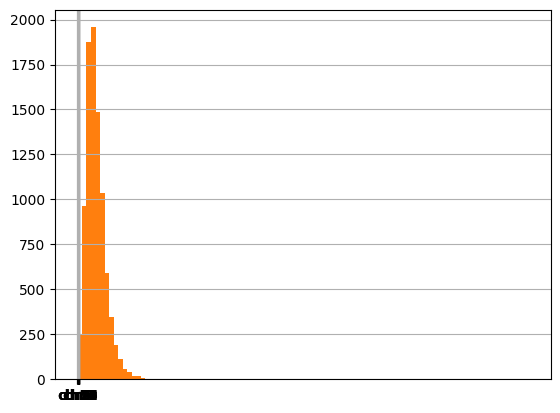

In [ ]:
# Read and visualuse .bed file
pos_df = pd.read_csv('GSE107690_K562_High_confidence_peaks.bed',
 sep='\t', comment='t', header=None)
header = ['chrom', 'chromStart', 'chromEnd']
pos_df.columns = header[:len(pos_df.columns)]
pos_df['len'] = pos_df.chromEnd - pos_df.chromStart
pos_df.head()
plt.hist(pos_df.chrom, bins=len(pos_df.chrom.unique()))
pos_df.len.quantile(0.5)
pos_df.len[pos_df.len > 512].count()
pos_df.len[pos_df.len <= 512].count() / pos_df.len.count()
pos_df.len.hist(bins=100)

In [ ]:
# Filtration
quad_len = 512
pos_df_filter = pos_df[pos_df.len
 <= quad_len].copy().reset_index(drop=True)
pos_df_filter.len.max()
pos_df_filter['add_len'] = quad_len - pos_df_filter.len
pos_df_filter['left_add_len'] = (pos_df_filter.add_len
 / 2).astype('int64')
pos_df_filter['right_add_len'] = pos_df_filter.add_len \
 - pos_df_filter.left_add_len
pos_df_filter['new_chromStart'] = pos_df_filter.chromStart \
 - pos_df_filter.left_add_len
pos_df_filter['new_chromEnd'] = pos_df_filter.chromEnd \
 + pos_df_filter.right_add_len
pos_df_filter['new_len'] = pos_df_filter.new_chromEnd \
 - pos_df_filter.new_chromStart
pos_df_filter.head()

,chrom,chromStart,chromEnd,len,add_len,left_add_len,right_add_len,new_chromStart,new_chromEnd,new_len
0,chr1,713977,714310,333,179,89,90,713888,714400,512
1,chr1,762850,762982,132,380,190,190,762660,763172,512
2,chr1,840076,840205,129,383,191,192,839885,840397,512
3,chr1,894635,894796,161,351,175,176,894460,894972,512
4,chr1,935414,935699,285,227,113,114,935301,935813,512


In [ ]:
# Save data
pos_df_filter[['chrom', 'new_chromStart', 'new_chromEnd'
 ]].to_csv('G4_Chip_seq_filter_norm_to_500.bed', sep='\t',
 header=None, index=None)
pos_df_filter[['chrom', 'chromStart', 'chromEnd'
 ]].to_csv('G4_Chip_seq_filter_500.bed', sep='\t',
 header=None, index=None)
pos_df_filter.to_csv('G4_Chip_seq_positions.csv')

In [ ]:
# One Hot Encoding
import numpy as np
from sklearn.preprocessing import OneHotEncoder
codes = {
 'A': [1., 0., 0., 0., 0.],
 'T': [0., 1., 0., 0., 0.],
 'G': [0., 0., 1., 0., 0.],
 'C': [0., 0., 0., 1., 0.],
 'N': [0., 0., 0., 0., 1.],
 }
pos_df_filter = pd.read_csv('G4_Chip_seq_positions.csv', index_col=0)
pos_df_filter.head()

,chrom,chromStart,chromEnd,len,add_len,left_add_len,right_add_len,new_chromStart,new_chromEnd,new_len
0,chr1,713977,714310,333,179,89,90,713888,714400,512
1,chr1,762850,762982,132,380,190,190,762660,763172,512
2,chr1,840076,840205,129,383,191,192,839885,840397,512
3,chr1,894635,894796,161,351,175,176,894460,894972,512
4,chr1,935414,935699,285,227,113,114,935301,935813,512


In [ ]:
# Normalisation
one_hot_quads = []
line_num = 0
with open('G4_Chip_seq_quadruplex_norm_to_500.fa', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      one_hot = []
      for s in line.upper():
        if s != '\n':
          one_hot.append(codes[s])
      one_hot_quads.append(one_hot)
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape


(8723, 512, 5)

In [ ]:
one_hot_quads_np

array([[[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.]],

       [[0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]],

       [[0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]],

       ...,

       [[0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]],

       [[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.]],

       [[0.,

In [ ]:
# Save
np.save('G4_Chip_seq_quadruplex_norm.npy', one_hot_quads_np)

In [ ]:
# Normalisation + labeling
one_hot_quads = []
line_num = 0
with open('G4_Chip_seq_quadruplex_norm_to_500.fa', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      left = pos_df_filter.iloc[line_num].left_add_len
      right = left + pos_df_filter.iloc[line_num].len
      one_hot = []
      for (i, s) in enumerate(line.upper()):
        pos = 0.
        if left <= i and i < right:
          pos = 1.
        if s != '\n':
          one_hot.append(codes[s] + [pos])
      one_hot_quads.append(np.array(one_hot))
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape
np.save('G4_Chip_seq_quadruplex_norm_quad_labeled.npy',
 one_hot_quads_np)

In [ ]:
import numpy as np

# Load the .npy file
data = np.load('G4_Chip_seq_quadruplex_norm_quad_labeled.npy')

# Access and work with the loaded data
# For example, print the shape of the data
print(data.shape)


(8723, 512, 6)


In [ ]:
import numpy as np

# Load the .npy file
data = np.load('G4_Chip_seq_quadruplex_norm.npy')

# Access and work with the loaded data
# For example, print the shape of the data
print(data.shape)

(8723, 512, 5)
